## Import Libraries

In [ ]:
!pip -q install vit_pytorch linformer

In [1]:
import os # system-wide functions
import numpy as np # For numerical computation
import scipy.io as sio# reading matlab files in python
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt # For plotting graphs(Visualization)
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from vit_torch.efficient import ViT
import glob
from torch.utils.tensorboard import SummaryWriter
import time
from linformer import Linformer
from vit_torch.ResNet import myResNet
import dask.dataframe as dd
import pickle

## Load Data

In [ ]:
class BpDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        file = self.file_list[idx]
        data = dd.read_parquet(file).compute()
        return np.array(data.ppg_data), np.array(data.norm_abp_data)



Load Datasets

In [ ]:
batch_size = 1

test_dir = 'data/tmp'

test_list = glob.glob(os.path.join(test_dir,'*.parquet'))
test_data = BpDataset(test_list)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)


In [ ]:
print(len(test_loader), len(test_loader))

### Testning

In [17]:
model_path = 'model/class_N_10_sqe_len_125_transform/model_99.pth'
efficient_transformer = Linformer(
    dim=1024,
    seq_len=10+1,
    depth=12,
    heads=8,
    k=64
)
model = ViT(
    sequence_len = 125,
    num_patches = 10,
    dim=1024,
    transformer=efficient_transformer
).to("cuda")
model.load_state_dict(torch.load(model_path))

max_ppg = 3.34217
min_ppg = -3.06697
max_abp = 199.9875
min_abp = 50

In [22]:
state_dict = torch.load(model_path)#xxx.pth或者xxx.pt就是你想改掉的权重文件
torch.save(state_dict, "model_ver_old.pth", _use_new_zipfile_serialization=False)


In [ ]:
with torch.no_grad():
        X_test = []
        Y_test = []
        Y_pred = []
        for data, label in test_loader:
            data = data.to("cuda")
            label = label.to("cuda")
            output = model(data)
            X_test.append(data.cpu().numpy())
            Y_test.append(label.cpu().numpy())
            Y_pred.append(output.cpu().numpy())
        pickle.dump(X_test,open('X_test.p','wb'))
        pickle.dump(Y_test,open('Y_test.p','wb'))
        pickle.dump(Y_pred,open('Y_pred.p','wb'))


In [2]:
# X_test = pickle.load(open('X_test.p', 'rb'))
# Y_test = pickle.load(open('Y_test.p', 'rb'))
# Y_pred = pickle.load(open('Y_pred.p', 'rb'))

In [5]:
import pickle
import os
from tqdm import tqdm
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
sns.set()

max_ppg = 3.34217
min_ppg = -3.06697
max_abp = 199.9875
min_abp = 50

In [ ]:
#plot wave

while(True):			# interactive cli

    indix = int(input(
        'Please input a record from 1 to 51412 to visualize.\nInput -1 to quit.\n> '))

    if(indix == -1):			# exit
        break

    if(indix < 1 or indix > 51412):			# wrong index
        continue

    indix -= 1

    #ppg_signal = X_test[indix] * (max_ppg -min_ppg) + min_ppg											# input ppg signal
    ppg_signal = X_test[indix]
    abp_signal_pred = Y_pred[indix] * (max_abp -min_abp) + min_abp		# abp waveform approx.
    #abp_signal_pred = Y_test_pred[indix] * max_abp + min_abp								# abp waveform predicted
    abp_signal_ground_truth = Y_test[indix] * (max_abp -min_abp) + min_abp								# abp waveform ground truth

    time_scale = np.arange(0, 10, 10/(ppg_signal.shape[1]))									# series for time axis

    plt.figure(figsize=(30, 15))

    plt.subplot(5, 1, 1)
    plt.plot(time_scale, ppg_signal[0], c='k', linewidth=2)
    plt.title('Input PPG Signal', fontsize=20)

    plt.subplot(5, 1, 2)
    plt.plot(time_scale, abp_signal_pred[0], c='r', linewidth=2)
    plt.ylabel('ABP (mmHg)', fontsize=15)
    plt.title('Output of Approximate Network', fontsize=20)

    # plt.subplot(5, 1, 3)
    # plt.plot(time_scale, abp_signal_pred, c='b', linewidth=2)
    # plt.ylabel('ABP (mmHg)', fontsize=15)
    # plt.title('Output of Refinement Network', fontsize=20)

    plt.subplot(5, 1, 4)
    plt.plot(time_scale, abp_signal_ground_truth[0], c='g', linewidth=2)
    plt.ylabel('ABP (mmHg)', fontsize=15)
    plt.title('Ground Truth', fontsize=20)

    plt.subplot(5, 1, 5)
    plt.plot(time_scale, abp_signal_pred[0], c='r', label='Output Level 1', linewidth=2)
    #plt.plot(time_scale, abp_signal_pred, c='b', label='Output Level 2', linewidth=2)
    plt.plot(time_scale, abp_signal_ground_truth[0], c='g', label='Ground Truth', linewidth=2)
    plt.title('Comparison', fontsize=20)
    plt.xlabel('Time (sec)', fontsize=15)
    plt.ylabel('ABP (mmHg)', fontsize=15)

    plt.tight_layout()

    plt.show()

In [6]:
def evaluate_BHS_Standard():
	"""
		Evaluates PPG2ABP based on
		BHS Standard Metric
	"""

	def newline(p1, p2):
		"""
		Draws a line between two points
		
		Arguments:
			p1 {list} -- coordinate of the first point
			p2 {list} -- coordinate of the second point
		
		Returns:
			mlines.Line2D -- the drawn line
		"""
		ax = plt.gca()
		xmin, xmax = ax.get_xbound()

		if(p2[0] == p1[0]):
			xmin = xmax = p1[0]
			ymin, ymax = ax.get_ybound()
		else:
			ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
			ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

		l = mlines.Line2D([xmin, xmax], [ymin, ymax], linewidth=1, linestyle='--')
		ax.add_line(l)
		return l

	def BHS_metric(err):
		"""
		Computes the BHS Standard metric
		
		Arguments:
			err {array} -- array of absolute error
		
		Returns:
			tuple -- tuple of percentage of samples with <=5 mmHg, <=10 mmHg and <=15 mmHg error
		"""

		leq5 = 0
		leq10 = 0
		leq15 = 0

		for i in range(len(err)):

			if(abs(err[i]) <= 5):
				leq5 += 1
				leq10 += 1
				leq15 += 1

			elif(abs(err[i]) <= 10):
				leq10 += 1
				leq15 += 1

			elif(abs(err[i]) <= 15):
				leq15 += 1

		return (leq5*100.0/len(err), leq10*100.0/len(err), leq15*100.0/len(err))

	def calcError(Ytrue, Ypred, max_abp, min_abp, max_ppg, min_ppg):
		"""
		Calculates the absolute error of sbp,dbp,map etc.
		
		Arguments:
			Ytrue {array} -- ground truth
			Ypred {array} -- predicted
			max_abp {float} -- max value of abp signal
			min_abp {float} -- min value of abp signal
			max_ppg {float} -- max value of ppg signal
			min_ppg {float} -- min value of ppg signal
		
		Returns:
			tuple -- tuple of abs. errors of sbp, dbp and map calculation
		"""

		sbps = []
		dbps = []
		maps = []
		maes = []
		gt = []

		hist = []

		for i in (range(len(Ytrue))):
			y_t = Ytrue[i].ravel()
			y_p = Ypred[i].ravel()

			dbps.append(max_abp*abs(min(y_t)-min(y_p)))
			sbps.append(max_abp*abs(max(y_t)-max(y_p)))
			maps.append(max_abp*abs(np.mean(y_t)-np.mean(y_p)))

		return (sbps, dbps, maps)

	#X_test = pickle.load(open('X_test.p', 'rb'))			# loading test data
	Y_test = pickle.load(open('Y_test.p', 'rb'))			# loading test data
	Y_pred = pickle.load(open('Y_pred.p', 'rb'))			# loading prediction

	(sbps, dbps, maps) = calcError(Y_test, Y_pred, max_abp, min_abp, max_ppg, min_ppg)   # compute errors

	sbp_percent = BHS_metric(sbps)											# compute BHS metric for sbp
	dbp_percent = BHS_metric(dbps)											# compute BHS metric for dbp
	map_percent = BHS_metric(maps)											# compute BHS metric for map

	print('----------------------------')
	print('|        BHS-Metric        |')
	print('----------------------------')

	print('----------------------------------------')
	print('|     | <= 5mmHg | <=10mmHg | <=15mmHg |')
	print('----------------------------------------')
	print('| DBP |  {} %  |  {} %  |  {} %  |'.format(round(dbp_percent[0], 1), round(dbp_percent[1], 1), round(dbp_percent[2], 1)))
	print('| MAP |  {} %  |  {} %  |  {} %  |'.format(round(map_percent[0], 1), round(map_percent[1], 1), round(map_percent[2], 1)))
	print('| SBP |  {} %  |  {} %  |  {} %  |'.format(round(sbp_percent[0], 1), round(sbp_percent[1], 1), round(sbp_percent[2], 1)))
	print('----------------------------------------')

	'''
		Plot figures
	'''

	## SBPS ##

	fig = plt.figure(figsize=(18, 4), dpi=120)
	ax1 = plt.subplot(1,3,1)
	ax2 = ax1.twinx()
	sns.distplot(sbps, bins=100, kde=False, rug=False, ax=ax1)
	sns.distplot(sbps, bins=100, kde=False, rug=False, ax=ax2)
	ax2.set_yticklabels(['0 \%', '3.67 \%', '7.34 \%',
						'11.01 \%', '14.67 \%', '18.34 \%', '22.01 \%'])
	ax1.set_xlabel(r'$|$'+'Error'+r'$|$' + ' (mmHg)', fontsize=14)
	ax1.set_ylabel('Number of Samples', fontsize=14)
	ax2.set_ylabel('Percentage of Samples', fontsize=14)
	plt.title('Absolute Error in SBP Prediction', fontsize=18)
	plt.xlim(xmax=60.0, xmin=0.0)
	plt.xticks(np.arange(0, 60+1, 5))
	p1 = [5, 0]
	p2 = [5, 10000]
	newline(p1, p2)
	p1 = [10, 0]
	p2 = [10, 10000]
	newline(p1, p2)
	p1 = [15, 0]
	p2 = [15, 10000]
	newline(p1, p2)
	plt.tight_layout()

	## DBPS ##

	
	ax1 = plt.subplot(1,3,2)
	ax2 = ax1.twinx()
	sns.distplot(dbps, bins=100, kde=False, rug=False, ax=ax1)
	sns.distplot(dbps, bins=100, kde=False, rug=False, ax=ax2)
	ax2.set_yticklabels(['0 \%', '7.34 \%', '14.67 \%',
						'22.01 \%', '29.35 \%', '36.68 \%', '44.02 \%'])
	ax1.set_xlabel(r'$|$'+'Error'+r'$|$' + ' (mmHg)', fontsize=14)
	ax1.set_ylabel('Number of Samples', fontsize=14)
	ax2.set_ylabel('Percentage of Samples', fontsize=14)
	plt.title('Absolute Error in DBP Prediction', fontsize=18)
	plt.xlim(xmax=60.0, xmin=0.0)
	plt.xticks(np.arange(0, 60+1, 5))
	p1 = [5, 0]
	p2 = [5, 10000]
	newline(p1, p2)
	p1 = [10, 0]
	p2 = [10, 10000]
	newline(p1, p2)
	p1 = [15, 0]
	p2 = [15, 10000]
	newline(p1, p2)
	plt.tight_layout()

	## MAPS ##

	
	ax1 = plt.subplot(1,3,3)
	ax2 = ax1.twinx()
	sns.distplot(maps, bins=100, kde=False, rug=False, ax=ax1)
	sns.distplot(maps, bins=100, kde=False, rug=False, ax=ax2)
	ax2.set_yticklabels(['0 \%', '7.34 \%', '14.67 \%', '22.01 \%',
						'29.35 \%', '36.68 \%', '44.02 \%', '51.36 \%'])
	ax1.set_xlabel(r'$|$'+'Error'+r'$|$' + ' (mmHg)', fontsize=14)
	ax1.set_ylabel('Number of Samples', fontsize=14)
	ax2.set_ylabel('Percentage of Samples', fontsize=14)
	plt.title('Absolute Error in MAP Prediction', fontsize=18)
	plt.xlim(xmax=60.0, xmin=0.0)
	plt.xticks(np.arange(0, 60+1, 5))
	p1 = [5, 0]
	p2 = [5, 10000]
	newline(p1, p2)
	p1 = [10, 0]
	p2 = [10, 10000]
	newline(p1, p2)
	p1 = [15, 0]
	p2 = [15, 10000]
	newline(p1, p2)
	plt.tight_layout()

	plt.show()

----------------------------
|        BHS-Metric        |
----------------------------
----------------------------------------
|     | <= 5mmHg | <=10mmHg | <=15mmHg |
----------------------------------------
| DBP |  91.7 %  |  91.7 %  |  100.0 %  |
| MAP |  58.3 %  |  91.7 %  |  100.0 %  |
| SBP |  25.0 %  |  50.0 %  |  66.7 %  |
----------------------------------------


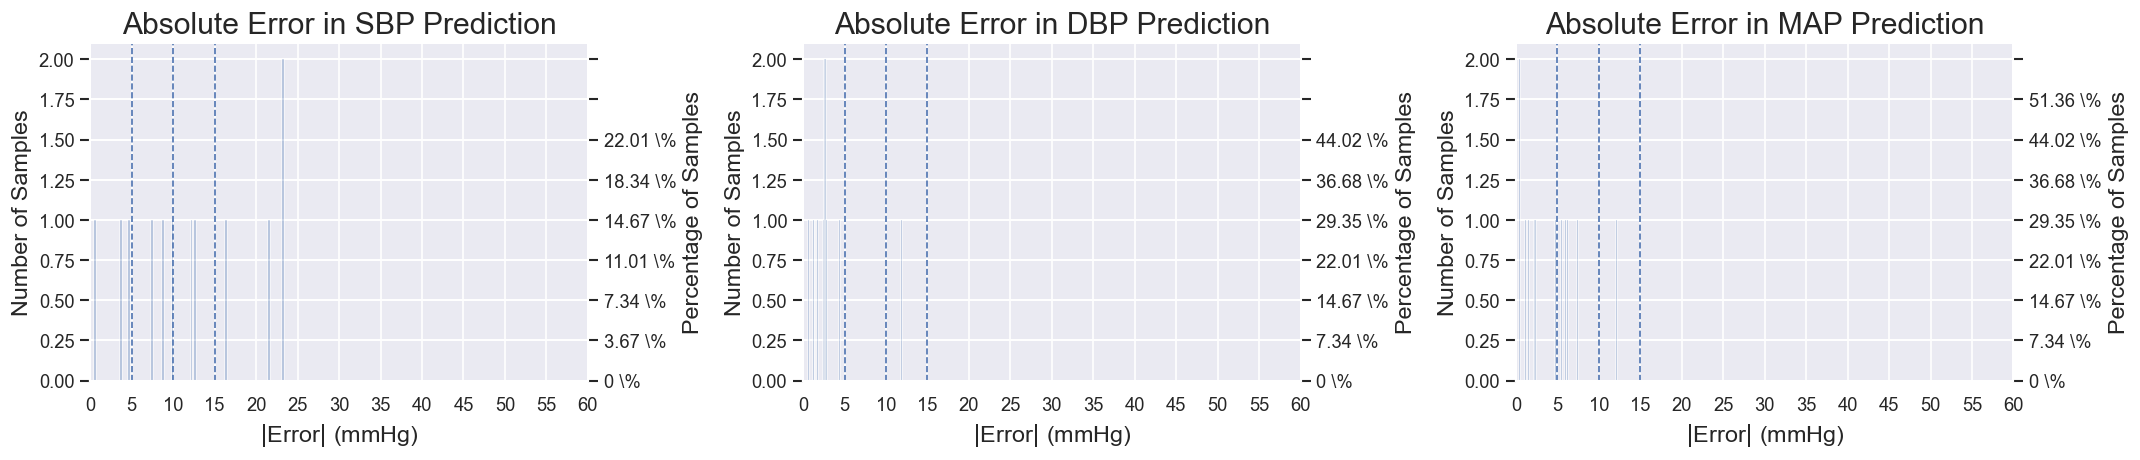

In [7]:
evaluate_BHS_Standard()

In [8]:
def evaluate_AAMI_Standard():
	"""
		Evaluate PPG2ABP using AAMI Standard metric	
	"""

	def calcErrorAAMI(Ypred, Ytrue, max_abp, min_abp, max_ppg, min_ppg):
		"""
		Calculates error of sbp,dbp,map for AAMI standard computation
		
		Arguments:
			Ytrue {array} -- ground truth
			Ypred {array} -- predicted
			max_abp {float} -- max value of abp signal
			min_abp {float} -- min value of abp signal
			max_ppg {float} -- max value of ppg signal
			min_ppg {float} -- min value of ppg signal
		
		Returns:
			tuple -- tuple of errors of sbp, dbp and map calculation
		"""

		sbps = []
		dbps = []
		maps = []

		for i in (range(len(Ytrue))):
			y_t = Ytrue[i].ravel()
			y_p = Ypred[i].ravel()

			dbps.append(max_abp*(min(y_p)-min(y_t)))
			sbps.append(max_abp*(max(y_p)-max(y_t)))
			maps.append(max_abp*(np.mean(y_p)-np.mean(y_t)))

		return (sbps, dbps, maps)

	(sbps, dbps, maps) = calcErrorAAMI(Y_test, Y_pred, max_abp, min_abp, max_ppg, min_ppg)		# compute error

	print('---------------------')
	print('|   AAMI Standard   |')
	print('---------------------')

	print('-----------------------')
	print('|     |  ME   |  STD  |')
	print('-----------------------')
	print('| DBP | {} | {} |'.format(round(np.mean(dbps), 3), round(np.std(dbps), 3)))
	print('| MAP | {} | {} |'.format(round(np.mean(maps), 3), round(np.std(maps), 3)))
	print('| SBP | {} | {} |'.format(round(np.mean(sbps), 3), round(np.std(sbps), 3)))
	print('-----------------------')

	'''
		Plotting figures
	'''

	## DBPS ##

	fig = plt.figure(figsize=(18, 4), dpi=120)
	ax1 = plt.subplot(1, 3, 1)
	ax2 = ax1.twinx()
	sns.distplot(dbps, bins=100, kde=False, rug=False, ax=ax1)
	sns.distplot(dbps, bins=100, kde=False, rug=False, ax=ax2)
	ax2.set_yticklabels(['0 \%', '7.34 \%', '14.67 \%',
						'22.01 \%', '29.35 \%', '36.68 \%', '44.02 \%'])
	ax1.set_xlabel('Error (mmHg)', fontsize=14)
	ax1.set_ylabel('Number of Samples', fontsize=14)
	ax2.set_ylabel('Percentage of Samples', fontsize=14)
	plt.title('Error in DBP Prediction', fontsize=18)
	plt.xlim(xmax=50.0, xmin=-50.0)
	#plt.xticks(np.arange(0, 60+1, 5))
	plt.tight_layout()

	## MAPS ##

	#fig = plt.figure(figsize=(6,4), dpi=120)
	ax1 = plt.subplot(1, 3, 2)
	ax2 = ax1.twinx()
	sns.distplot(maps, bins=100, kde=False, rug=False, ax=ax1)
	sns.distplot(maps, bins=100, kde=False, rug=False, ax=ax2)
	ax2.set_yticklabels(['0 \%', '7.34 \%', '14.67 \%', '22.01 \%',
						'29.35 \%', '36.68 \%', '44.02 \%', '51.36 \%'])
	ax1.set_xlabel('Error (mmHg)', fontsize=14)
	ax1.set_ylabel('Number of Samples', fontsize=14)
	ax2.set_ylabel('Percentage of Samples', fontsize=14)
	plt.title('Error in MAP Prediction', fontsize=18)
	plt.xlim(xmax=50.0, xmin=-50.0)
	#plt.xticks(np.arange(0, 60+1, 5))
	plt.tight_layout()

	## SBPS ##

	ax1 = plt.subplot(1, 3, 3)
	ax2 = ax1.twinx()
	sns.distplot(sbps, bins=100, kde=False, rug=False, ax=ax1)
	sns.distplot(sbps, bins=100, kde=False, rug=False, ax=ax2)
	ax2.set_yticklabels(['0 \%', '3.67 \%', '7.34 \%',
						'11.01 \%', '14.67 \%', '18.34 \%', '22.01 \%'])
	ax1.set_xlabel('Error (mmHg)', fontsize=14)
	ax1.set_ylabel('Number of Samples', fontsize=14)
	ax2.set_ylabel('Percentage of Samples', fontsize=14)
	plt.title('Error in SBP Prediction', fontsize=18)
	plt.xlim(xmax=50.0, xmin=-50.0)
	#plt.xticks(np.arange(0, 60+1, 5))
	plt.tight_layout()

	plt.show()

---------------------
|   AAMI Standard   |
---------------------
-----------------------
|     |  ME   |  STD  |
-----------------------
| DBP | -0.966 | 4.077 |
| MAP | -0.843 | 5.287 |
| SBP | 10.145 | 9.787 |
-----------------------


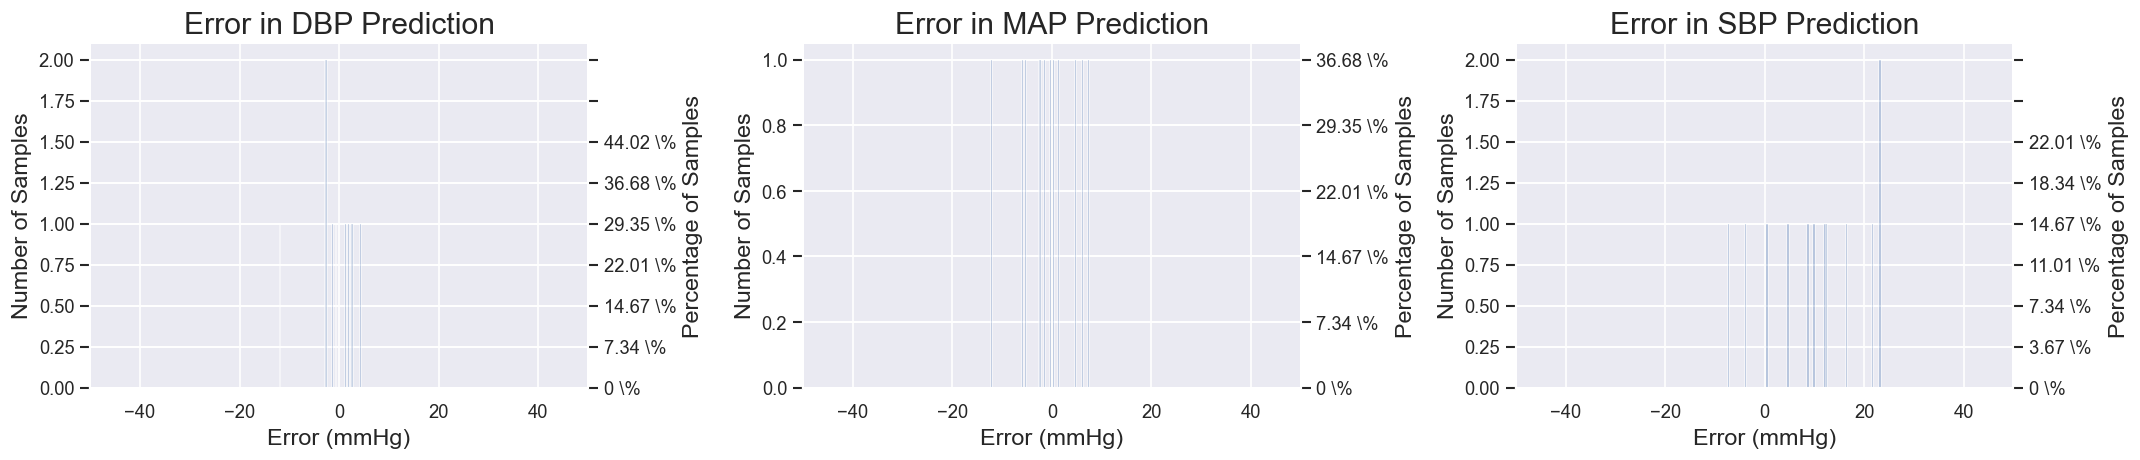

In [9]:
evaluate_AAMI_Standard()

In [15]:
def evaluate_BP_Classification():
	"""
		Evaluates PPG2ABP for BP Classification
	"""


	Ytrue = Y_test

	### DBPS ####

	cls_gt = []
	cls_pred = []

	for i in (range(len(Ytrue))):
		y_t = Ytrue[i].ravel()
		y_p = Y_pred[i].ravel()

		dbp_gt = max_abp*min(y_t)+min_abp
		dbp_pred = max_abp*min(y_p)+min_abp

		if(dbp_gt <= 80):
			cls_gt.append('Normotension')
		elif((dbp_gt > 80)and(dbp_gt <= 90)):
			cls_gt.append('Pre-hypertension')
		elif(dbp_gt > 90):
			cls_gt.append('Hypertension')
		else:
			print('bump')				# this will never happen, check for error

		if(dbp_pred <= 80):
			cls_pred.append('Normotension')
		elif((dbp_pred > 80)and(dbp_pred <= 90)):
			cls_pred.append('Pre-hypertension')
		elif(dbp_pred > 90):
			cls_pred.append('Hypertension')
		else:
			print('bump')				# this will never happen, check for error

	print('DBPS Classification Accuracy')
	print(classification_report(cls_gt, cls_pred, digits=5))
	# print('-'*25)
	# print(accuracy_score(cls_gt,cls_pred))

	cm = confusion_matrix(cls_gt, cls_pred)
	classes = ['Hypertension', 'Normotension', 'Prehypertension']
	cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
	fig = plt.figure(figsize=(16, 6), dpi=120)
	ax = plt.subplot(1,2,1)
	im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')			# draw confusion matrix

	divider = make_axes_locatable(ax)
	cax = divider.append_axes("right", size="5%", pad=0.25)

	ax.figure.colorbar(im, cax=cax)
	ax.set(xticks=np.arange(cm.shape[1]),
		yticks=np.arange(cm.shape[0]),
		xticklabels=classes, yticklabels=classes)

	ax.set_title('Hypertension Classification Accuracy Using DBP', fontsize=18)
	ax.set_ylabel('True label', fontsize=16)
	ax.set_xlabel('Predicted label', fontsize=16)

	plt.setp(ax.get_xticklabels(), rotation=45, fontsize=15,  ha="right",
		rotation_mode="anchor")

	plt.setp(ax.get_yticklabels(), fontsize=15)

	fmt = '.2f'
	thresh = cm.max() / 2.
	for i in range(cm.shape[0]):
		for j in range(cm.shape[1]):
			ax.text(j, i, format(cm[i, j], fmt),
					ha="center", va="center", fontsize=15,
					color="white" if cm[i, j] > thresh else "black")

	ax.grid(False)

	fig.tight_layout()


	### SBPS ####

	cls_gt = []
	cls_pred = []

	for i in (range(len(Ytrue))):
		y_t = Ytrue[i].ravel()
		y_p = Y_pred[i].ravel()

		sbp_gt = max_abp*max(y_t)+min_abp
		sbp_pred = max_abp*max(y_p)+min_abp

		if(sbp_gt <= 120):
			cls_gt.append('Normotension')
		elif((sbp_gt > 120)and(sbp_gt <= 140)):
			cls_gt.append('Prehypertension')
		elif(sbp_gt > 140):
			cls_gt.append('Hypertension')
		else:
			print('bump')				# this will never happen, check for error

		if(sbp_pred <= 120):
			cls_pred.append('Normotension')
		elif((sbp_pred > 120)and(sbp_pred <= 140)):
			cls_pred.append('Prehypertension')
		elif(sbp_pred > 140):
			cls_pred.append('Hypertension')
		else:
			print('bump')				# this will never happen, check for error

	print('SBPS Classification Accuracy')
	print(classification_report(cls_gt, cls_pred, digits=5))
	# print('-'*25)
	# print(accuracy_score(cls_gt,cls_pred))

	cm = confusion_matrix(cls_gt, cls_pred)
	classes = ['Hypertension', 'Normotension', 'Prehypertension']
	cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
	
	ax = plt.subplot(1,2,2)
	im = ax.imshow(cm, interpolation='nearest', cmap='GnBu')		# draw confusion matrix

	divider = make_axes_locatable(ax)
	cax = divider.append_axes("right", size="5%", pad=0.25)

	ax.figure.colorbar(im, cax=cax)
	ax.set(xticks=np.arange(cm.shape[1]),
		yticks=np.arange(cm.shape[0]),
		xticklabels=classes, yticklabels=classes)

	ax.set_title('Hypertension Classification Accuracy Using SBP', fontsize=18)
	ax.set_ylabel('True label', fontsize=16)
	ax.set_xlabel('Predicted label', fontsize=16)

	plt.setp(ax.get_xticklabels(), rotation=45, fontsize=15, ha="right",
			rotation_mode="anchor")

	plt.setp(ax.get_yticklabels(), fontsize=15)

	fmt = '.2f'
	thresh = cm.max() / 2.
	for i in range(cm.shape[0]):
		for j in range(cm.shape[1]):
			ax.text(j, i, format(cm[i, j], fmt),
					ha="center", va="center", fontsize=15,
					color="white" if cm[i, j] > thresh else "black")

	ax.grid(False)

	fig.tight_layout()

	plt.show()

DBPS Classification Accuracy
                  precision    recall  f1-score   support

    Normotension    1.00000   0.91667   0.95652        12
Pre-hypertension    0.00000   0.00000   0.00000         0

        accuracy                        0.91667        12
       macro avg    0.50000   0.45833   0.47826        12
    weighted avg    1.00000   0.91667   0.95652        12



ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (3).

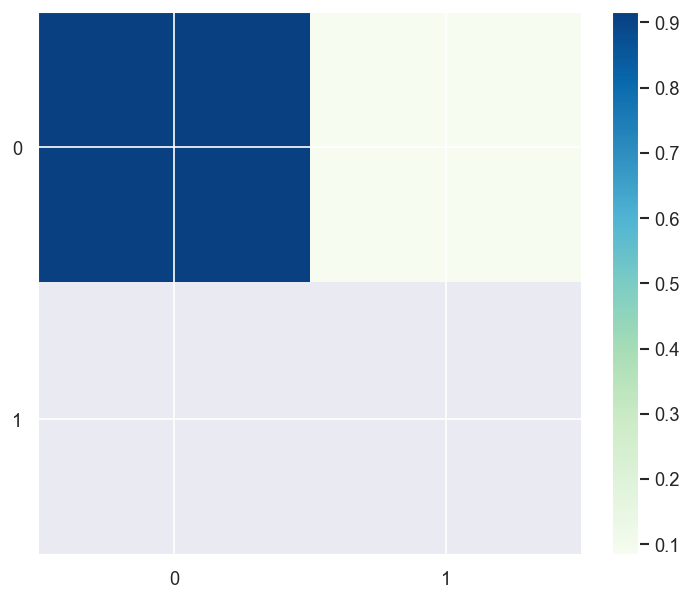

In [16]:
evaluate_BP_Classification()